# Variational Autoencoders for Anomaly Detection

In this lab we'll be training a variational autoencoder on the MNIST dataset.  We'll use the anomaly detection method described in [Variational Autoencoder based Anomaly Detection
using Reconstruction Probability, An, Cho, 2015](http://dm.snu.ac.kr/static/docs/TR/SNUDM-TR-2015-03.pdf).  Anomalies are detected by assuming that the datapoints are coming from a distribution that we can model effectively.  A datapoint is considered an anomaly if the probability of it being generated from the model is below a threshold.  Thresholds are set depending on the business/industry objective.

In this lab, we'll determine beforehand which digit 0-9 will be considered as anomalous and then try to detect the anomalous digits in the test set.  The VAE will be trained on the non-anomalous digits.  Note that this is a case of semi-supervised learning.

*Challenges will be included throughout the notebook.  These are meant as additional exercises to be done after going through the full notebook once.*

## Variational Autoencoders

We'll be using a Keras implementation of variational autoencoders.  The implementation can be found here (https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py)[https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py] and is based on (Auto-Encoding Variational Bayes, Kingma, Welling, 2014)[https://arxiv.org/pdf/1312.6114.pdf].

We begin by importing the libraries that we'll need and setting the hyperparameters to our model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import fashion_mnist, mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 400
epochs = 50
epsilon_std = 1.0 # standard deviation of normal distribution used to sample latent values
anomalous_digit = 5 # mnist digit to be inserted into test dataset of model trained on fashion-mnist data

Using TensorFlow backend.


*Challenge: investigate the effect (if any) of epsilon_std in reconstructing MNIST digits and detecting anomalies.*

Here we define the probabilistic encoder network. The encoder maps inputs to latent distribution parameters.

In [2]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

We have to sample values from the probabilistic encoder to o get the latent values.

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [4]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

The probabilistic decoder network maps latent values to a distribution that can be sampled to reconst the inputs.  With MNIST data we are assuming that the data is coming from a Bernoulli distribution hence we only need the means. 

In [5]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

Here we implement a custom loss layer in Keras.  The loss function is the sum of the binary cross-entropy loss and the KL divergence between the latent distribution and the standard normal distribution is used as a regularization term.

In [6]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

*Challenge: investigate the effects of training the VAE without the KL term.*

Instantiate end-to-end model for training

In [7]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


*Challenge: implement a VAE with convolutional layers*

Load the MNIST data.

In [8]:
# load MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
(x_trainMNIST, y_trainMNIST), (x_testMNIST, y_testMNIST) = mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [10]:
x_trainMINST = x_trainMNIST.astype('float32') / 255.
x_testMNIST = x_testMNIST.astype('float32') / 255.
x_trainMNIST = x_trainMNIST.reshape((len(x_trainMNIST), np.prod(x_trainMNIST.shape[1:])))
x_testMNIST = x_testMNIST.reshape((len(x_testMNIST), np.prod(x_testMNIST.shape[1:])))

In [11]:
targetDigitInds = np.where(y_testMNIST==anomalous_digit)[0]
x_testWithAnomaly = np.concatenate( [x_test, x_testMNIST[targetDigitInds, :]], axis=0)
y_testWithAnomaly = np.concatenate( [y_test, y_testMNIST[targetDigitInds]+10], axis=0)

In [12]:
%matplotlib notebook

<IPython.core.display.Javascript object>


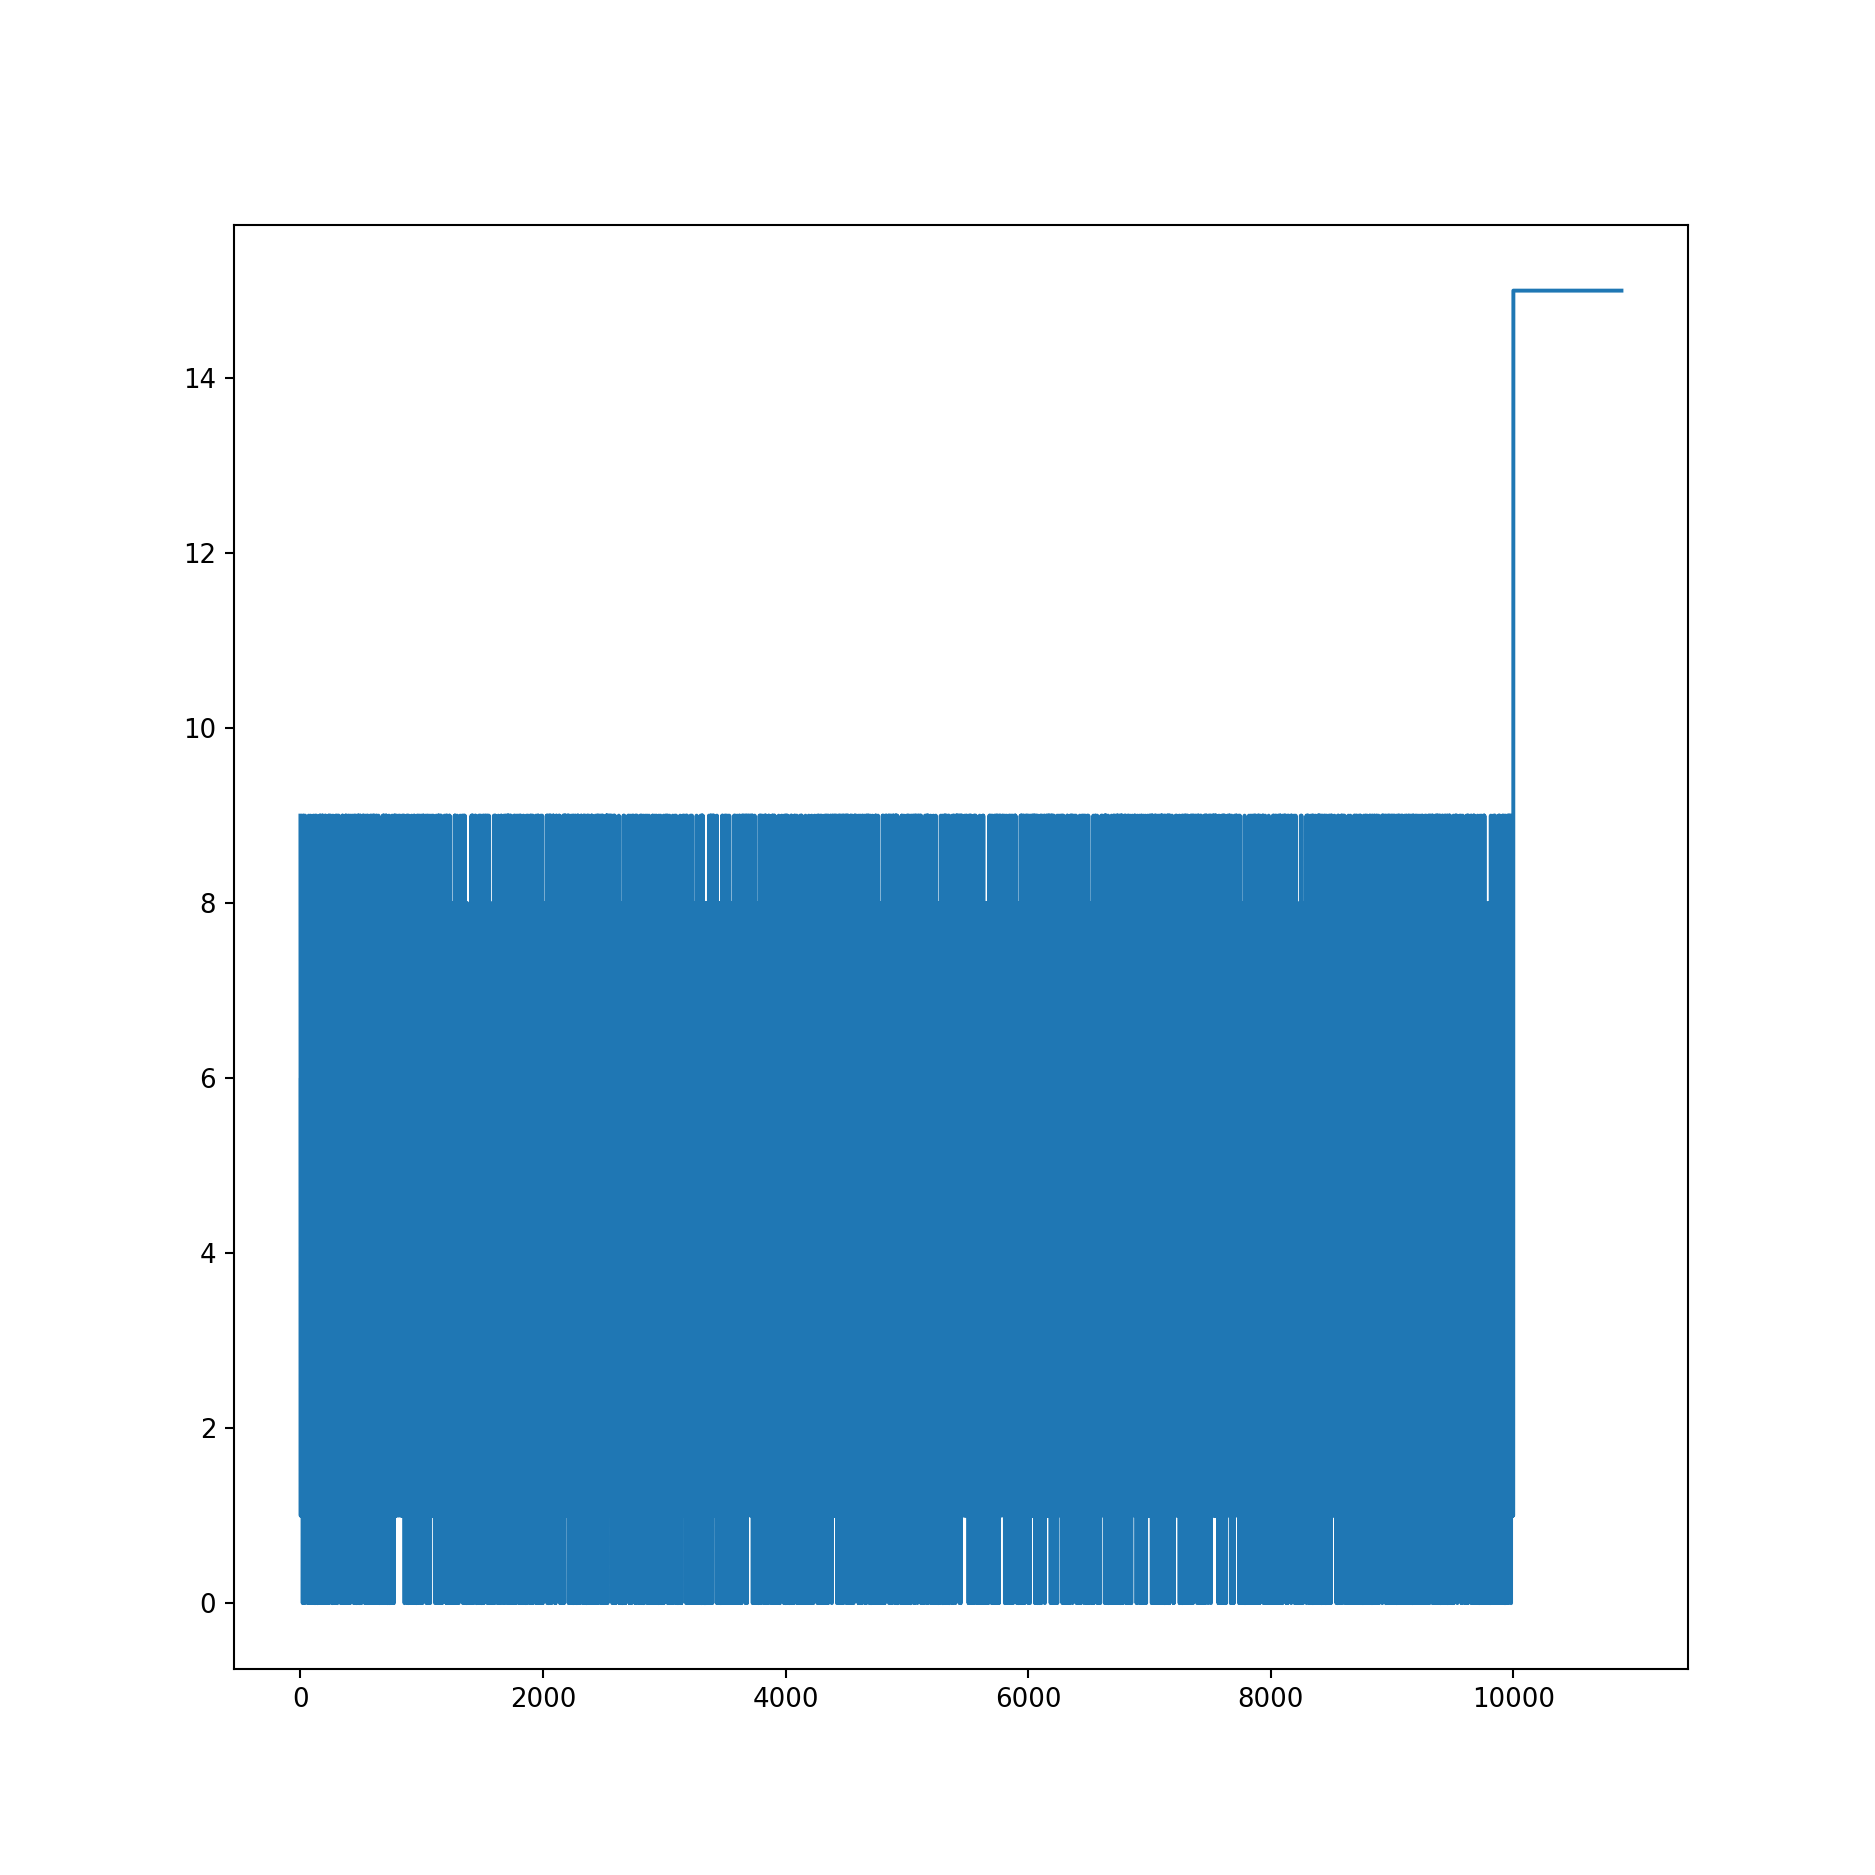

In [13]:
np.min(y_testWithAnomaly)
plt.figure(figsize=(10,10))
plt.plot(y_testWithAnomaly)
plt.show()

We remove the anomalous digits from the training data then we create labels for the anomaly detection task.  Images in the test set are labeled 1 if they are normal and labeled 0 if they are anomalous.

In [14]:
'''
# remove anomalous digit from train data
train_mask = np.where(y_train!=anomalous_digit)[0]
x_train = x_train[train_mask, :]
y_train = y_train[train_mask]
'''
# create binary labels
test_mask = np.where(y_testWithAnomaly != anomalous_digit+10)[0]

<IPython.core.display.Javascript object>


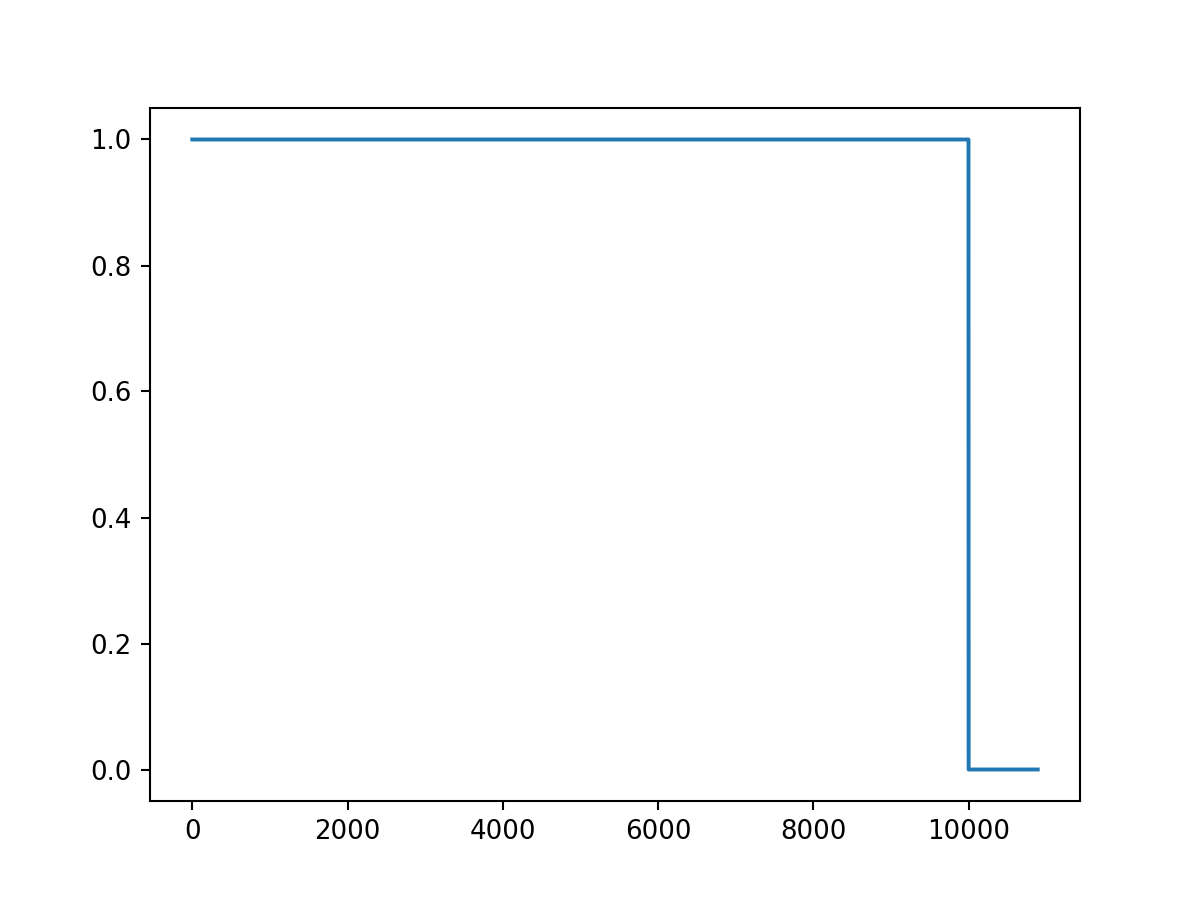

In [15]:
y_test_binary = np.zeros(y_testWithAnomaly.shape[0])
y_test_binary[test_mask] = 1
plt.figure()
plt.plot(y_test_binary)
plt.show()

Train on the MNIST data minus the anomalous digits.

In [16]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50
60000/60000 [==============================] - 5s 77us/step - loss: 301.2722
Epoch 2/50
60000/60000 [==============================] - 2s 33us/step - loss: 276.8983
Epoch 3/50
60000/60000 [==============================] - 2s 33us/step - loss: 273.3649
Epoch 4/50
60000/60000 [==============================] - 2s 33us/step - loss: 271.5383
Epoch 5/50
60000/60000 [==============================] - 2s 33us/step - loss: 270.2675
Epoch 6/50
60000/60000 [==============================] - 2s 33us/step - loss: 269.3257
Epoch 7/50
60000/60000 [==============================] - 2s 33us/step - loss: 268.4958
Epoch 8/50
60000/60000 [==============================] - 2s 33us/step - loss: 267.8319
Epoch 9/50
60000/60000 [==============================] - 2s 33us/step - loss: 267.3548
Epoch 10/50
60000/60000 [==============================] - 2s 33us/step - loss: 266.9072
Epoch 11/50
60000/60000 [==============================] - 2s 33us/step - loss: 266.4291
Epoch 12/50
60000/60000 [=====

## Visualize the Learned Latent Distribution

One of the benefits of variational autoencoders is that we can inspect the latent space to learn more about our model and our data.  In anomaly detection, latent variables can be used to try and determine the cause of anomalies.  This could potentially lead to proactively stopping anomalies from happening.  

In the case that we have 2 latent dimensions we can easily visualize the representation.  With higher dimensionality we can use dimensionality reducing techniques such as PCA or t-SNE to visualize.

Begin by instantiating an encoder model.

In [21]:
# build a model to project inputs on to the latent space
encoder = Model(x, z_mean)

# Looking at the data encoded in latent space ( with anomalies )

<IPython.core.display.Javascript object>


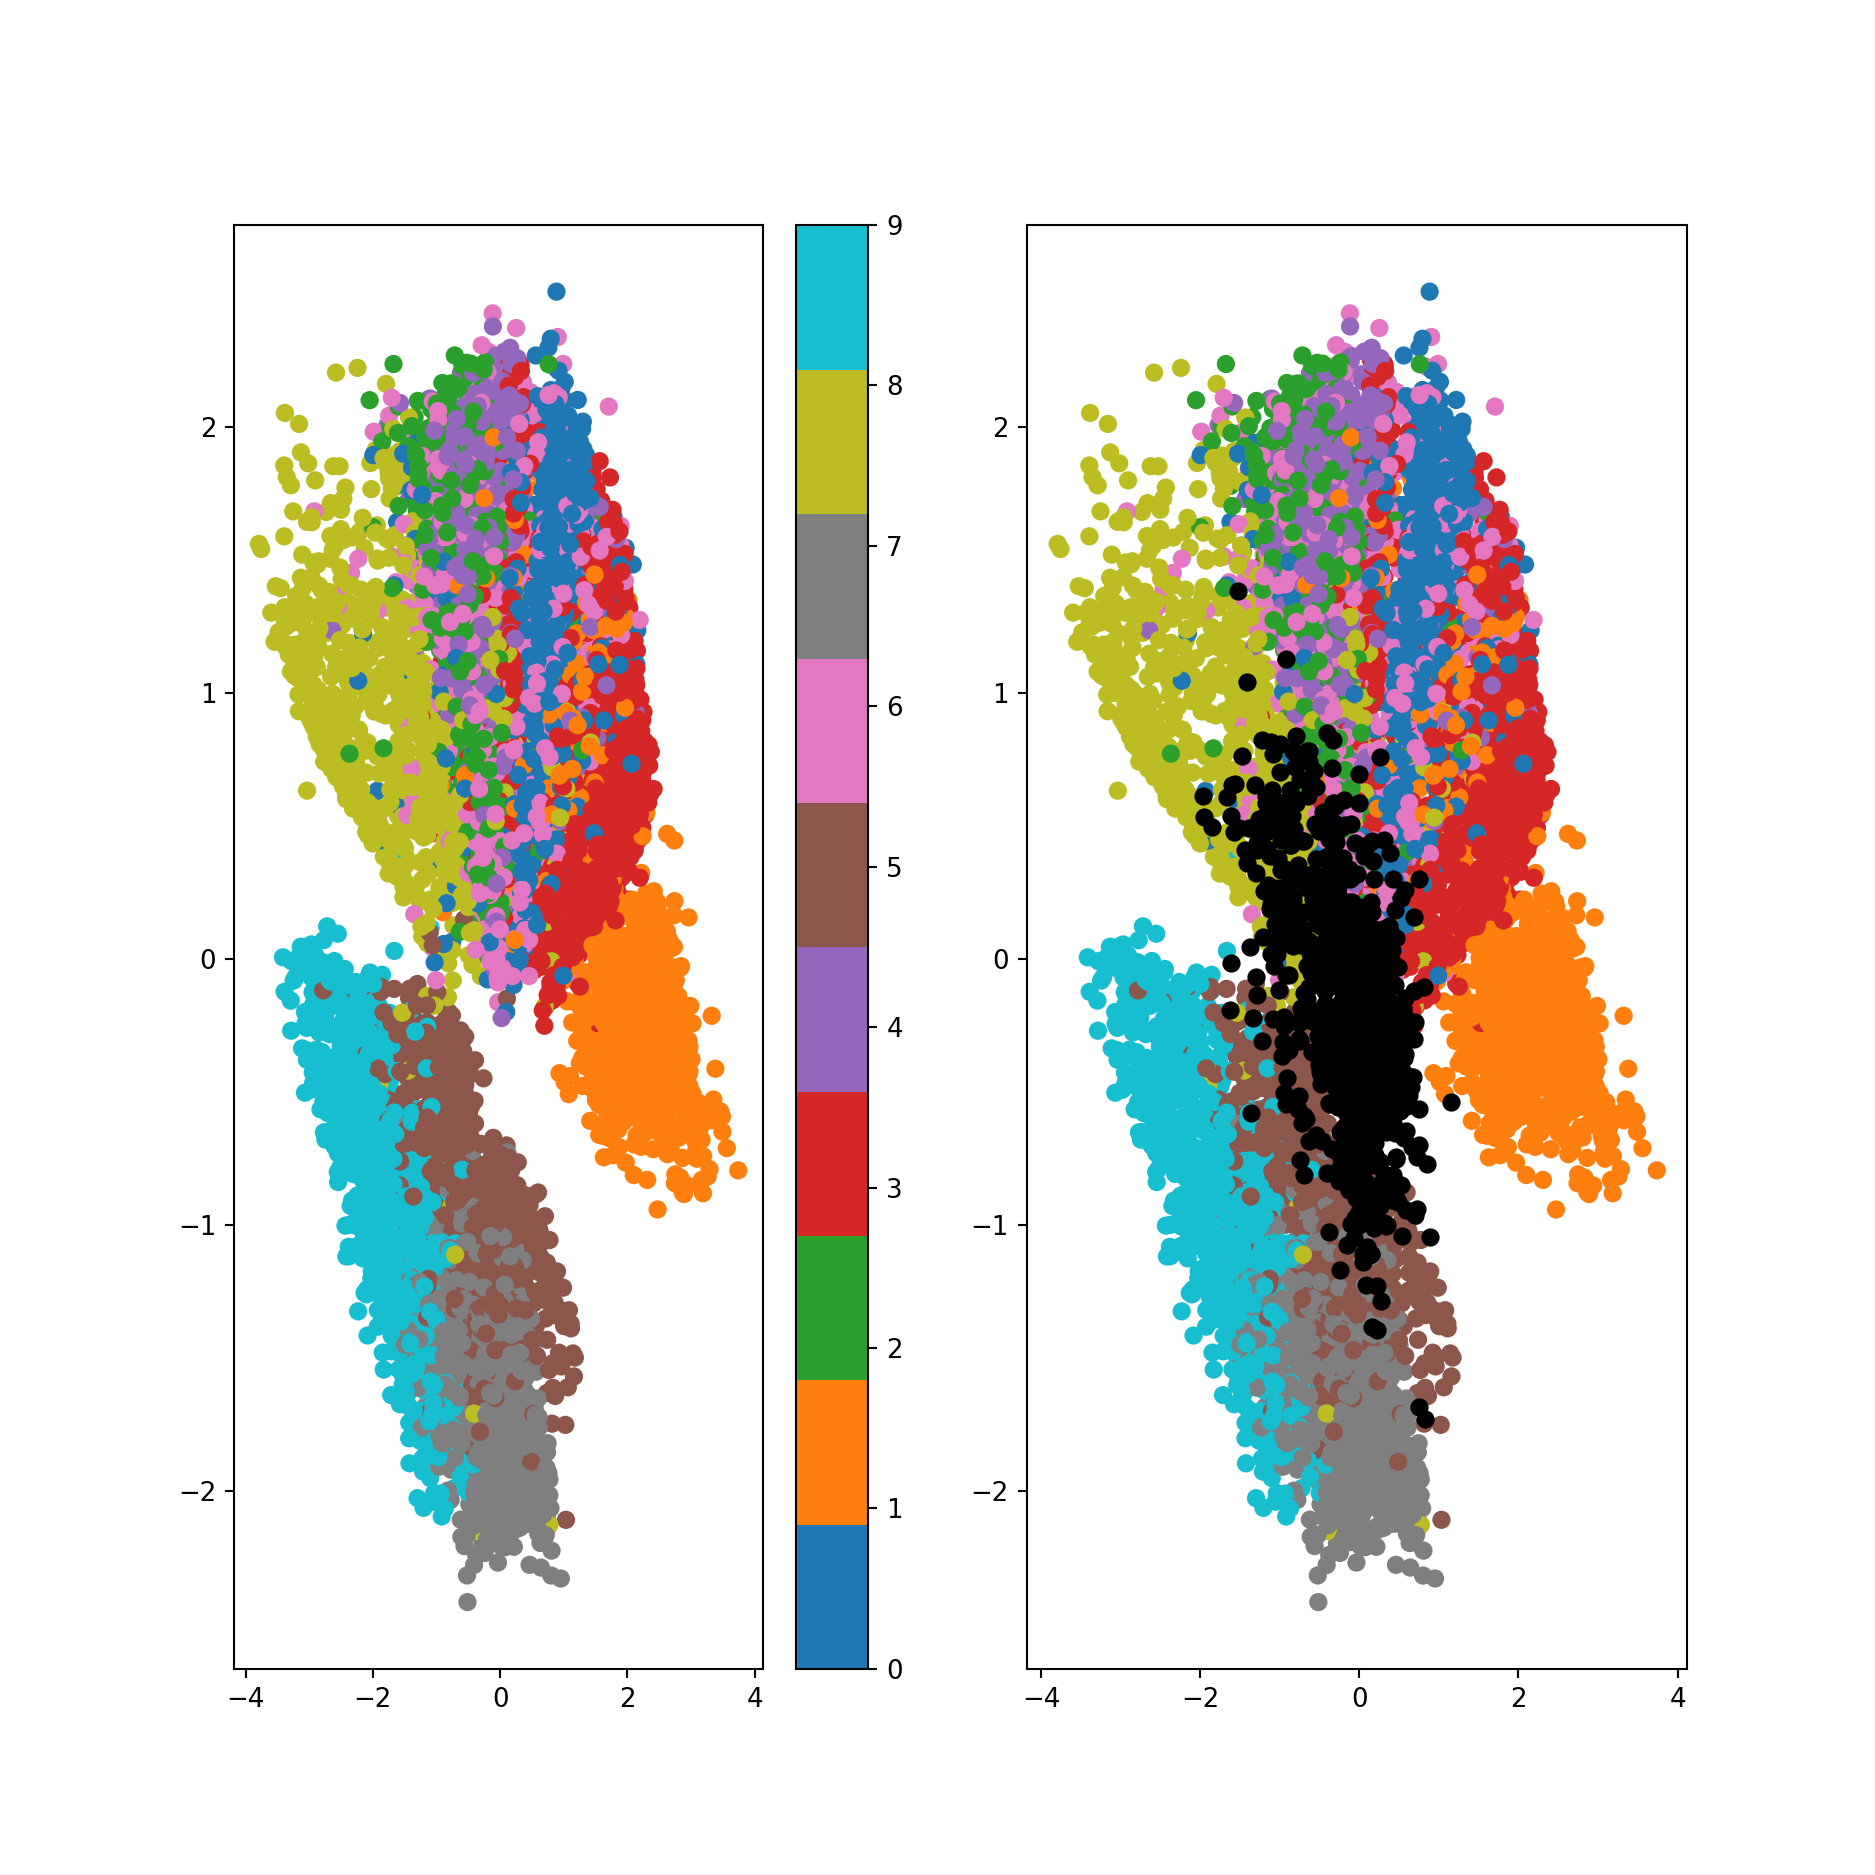

In [23]:
if latent_dim == 2:
    # display a 2D plot of the digit classes in the latent space
    plt.figure(figsize=(10,10))
    
    plt.subplot(1,2,1)
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
    plt.colorbar()
    
    plt.subplot(1,2,2)
    x_test_encodedWithAnomaly = encoder.predict(x_testWithAnomaly, batch_size=batch_size)
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
    
    anomalousInds = np.where(y_testWithAnomaly==anomalous_digit+10)[0]
    plt.scatter(x_test_encodedWithAnomaly[anomalousInds,0], x_test_encodedWithAnomaly[anomalousInds,1], 
                c=(0,0,0), cmap='tab10')    
    plt.show()

*Question: what abstract concepts are encoded in our latent dimensions?*

In [24]:
encodedMeans = np.mean( x_test_encoded, axis=0 )
encodedSTDs = np.std( x_test_encoded, axis=0 )
linspaceForGraph = np.linspace(-1,1,num=15)

In [25]:
xCoords = encodedMeans[0] + encodedSTDs[0] * linspaceForGraph
yCoords = encodedMeans[1] + encodedSTDs[1] * linspaceForGraph

Another key aspect of VAEs is that they are generative models.  By sampling latent values from our latent distribution our model can hallucinate MNIST digits.  

In [26]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

Below, we sweep out latent values along our two latent dimensions.  Recall that latent dimensions are supposed to be simple, abstract concepts which are then used by the decoder to create complex images.

<IPython.core.display.Javascript object>


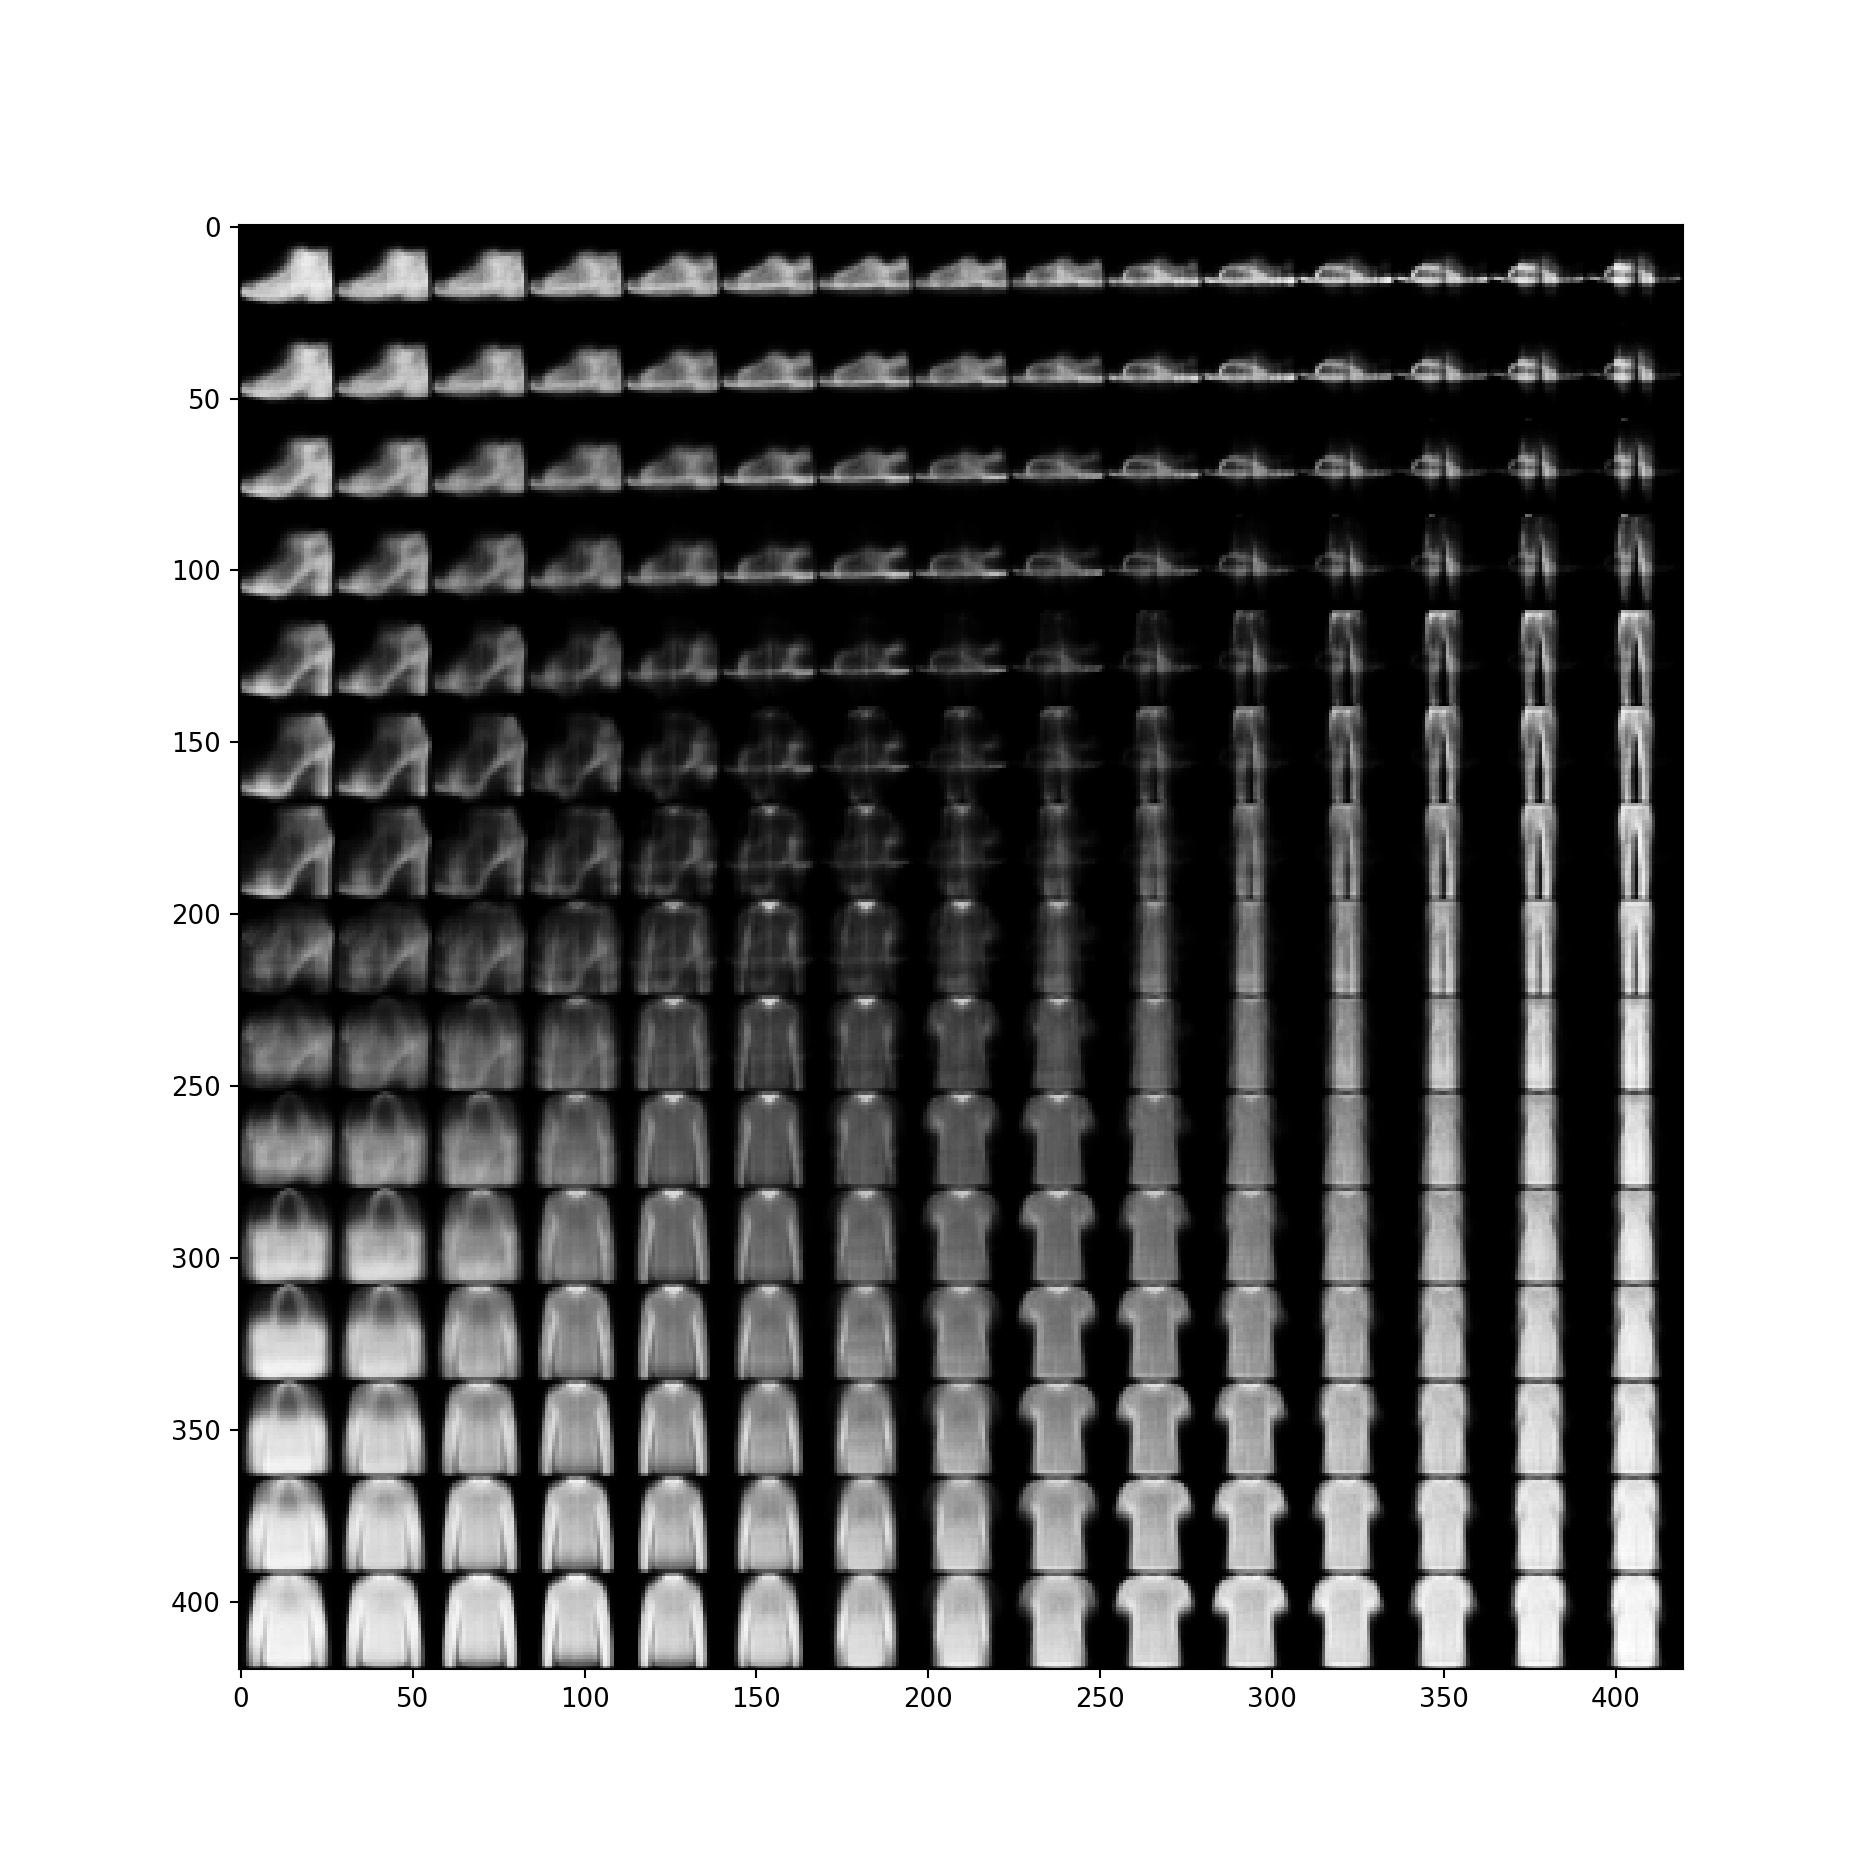

In [27]:
if latent_dim == 2:
    # display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = xCoords # norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = yCoords #norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = generator.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()    
else:
    print("Reduce latent dimensions to 2 using PCA or other techniques then visualize")

We can see that the latent values naturally cluster according to the class of digit.

## Anomaly Detection

We detect anomalies by computing the probability that our reconstructed datapoint came from the ground truth.  To do this we reconstruct all of the data in our test set and then compute the binary cross-entropy between ground truth digit and our reconstruction.  

In [28]:
# compute sigmoid output of the model on the input
sigmoid_output = Model(x, x_decoded_mean)

In [29]:
# compute reconstructions of the test set
x_test_recons = sigmoid_output.predict(x_testWithAnomaly)

To get the likelihood of our reconstruction we exponentiate the negative cross-entropy.

In [30]:
def recon_prob(output, target):
    xent = -(target*np.log(output + .0000001) + (1.0 - target) * np.log(1.0 - output + .0000001))
    xent = np.mean(xent, axis=1)
    return np.exp(-xent)

probs = recon_prob(x_test_recons, x_testWithAnomaly)

We can learn more about the effectiveness of our anomaly detector by visualizing the results.  Below we randomly sample ten images at a time from the test set.

<IPython.core.display.Javascript object>


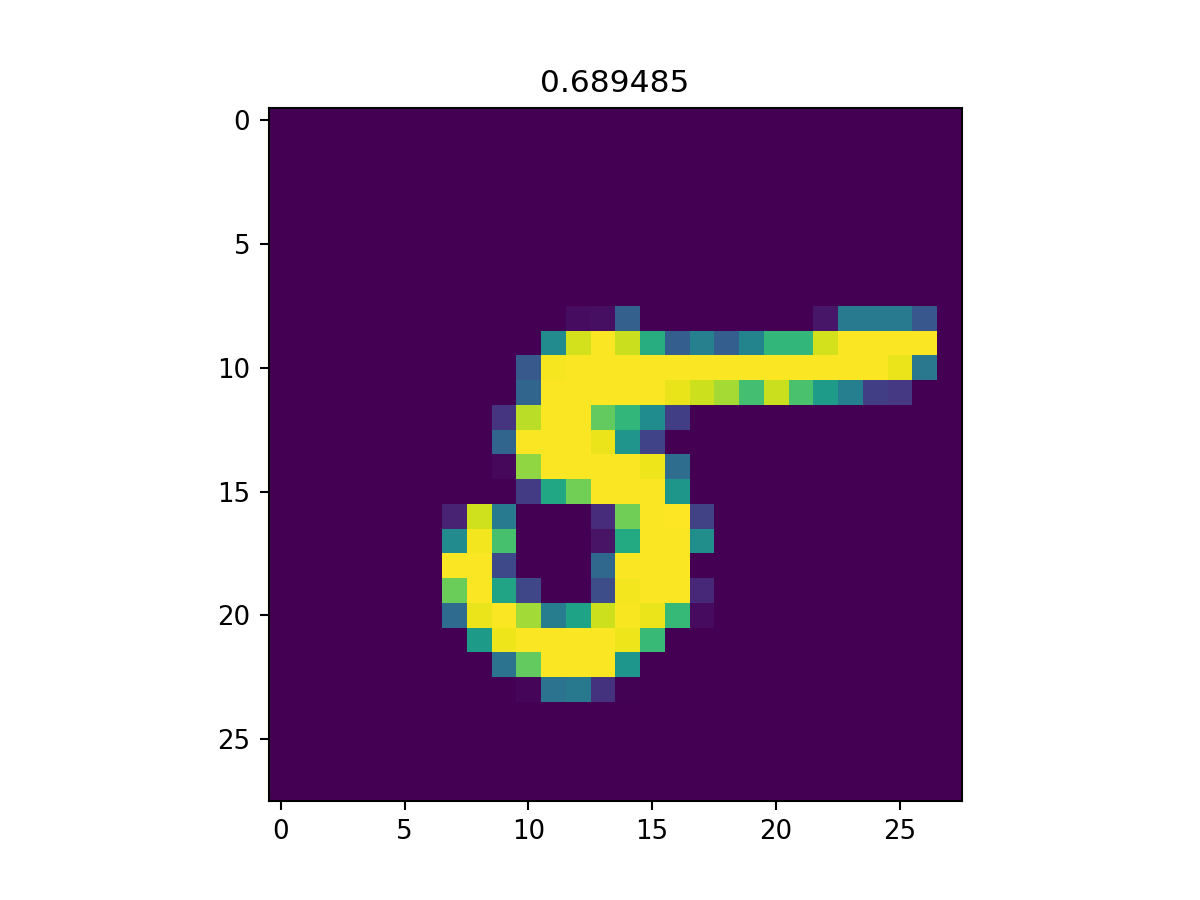

In [31]:
plt.figure()
ind = -1
plt.imshow(x_testWithAnomaly[ind,:].reshape(28,28))
plt.title(probs[ind])
plt.show()

<IPython.core.display.Javascript object>


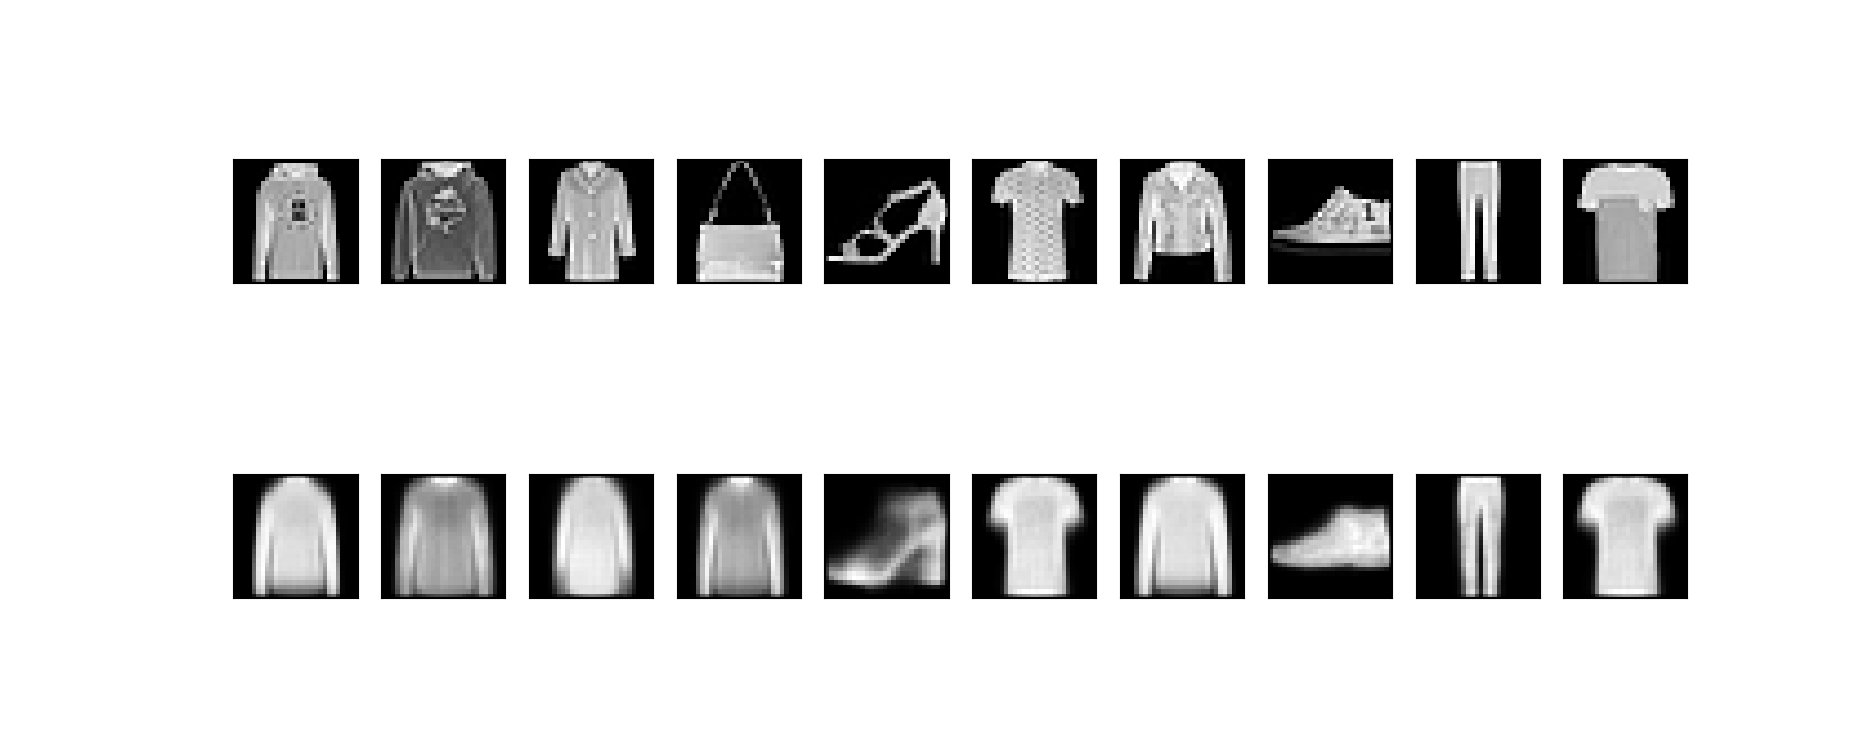

image index: 7753 normal: 1.0 probability: 0.675896
image index: 8114 normal: 1.0 probability: 0.600006
image index: 4173 normal: 1.0 probability: 0.67846
image index: 7765 normal: 1.0 probability: 0.638925
image index: 9976 normal: 1.0 probability: 0.754142
image index: 4335 normal: 1.0 probability: 0.713603
image index: 3683 normal: 1.0 probability: 0.665563
image index: 498 normal: 1.0 probability: 0.774634
image index: 5898 normal: 1.0 probability: 0.837001
image index: 9980 normal: 1.0 probability: 0.698522


In [33]:
# plot original digit, reconstruction, and probability
n = 10
plt.figure(figsize=(10, 4))
for i in range(1, n+1):
    img_idx = np.random.randint(0,y_testWithAnomaly.shape[0])
    print('image index: ' + str(img_idx) +
          ' normal: ' + str(y_test_binary[img_idx]) + 
          ' probability: ' + str(probs[img_idx]))
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_testWithAnomaly[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_recons[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It can be instructive to visualize what are the most normal images in our test set according to the model.

<IPython.core.display.Javascript object>


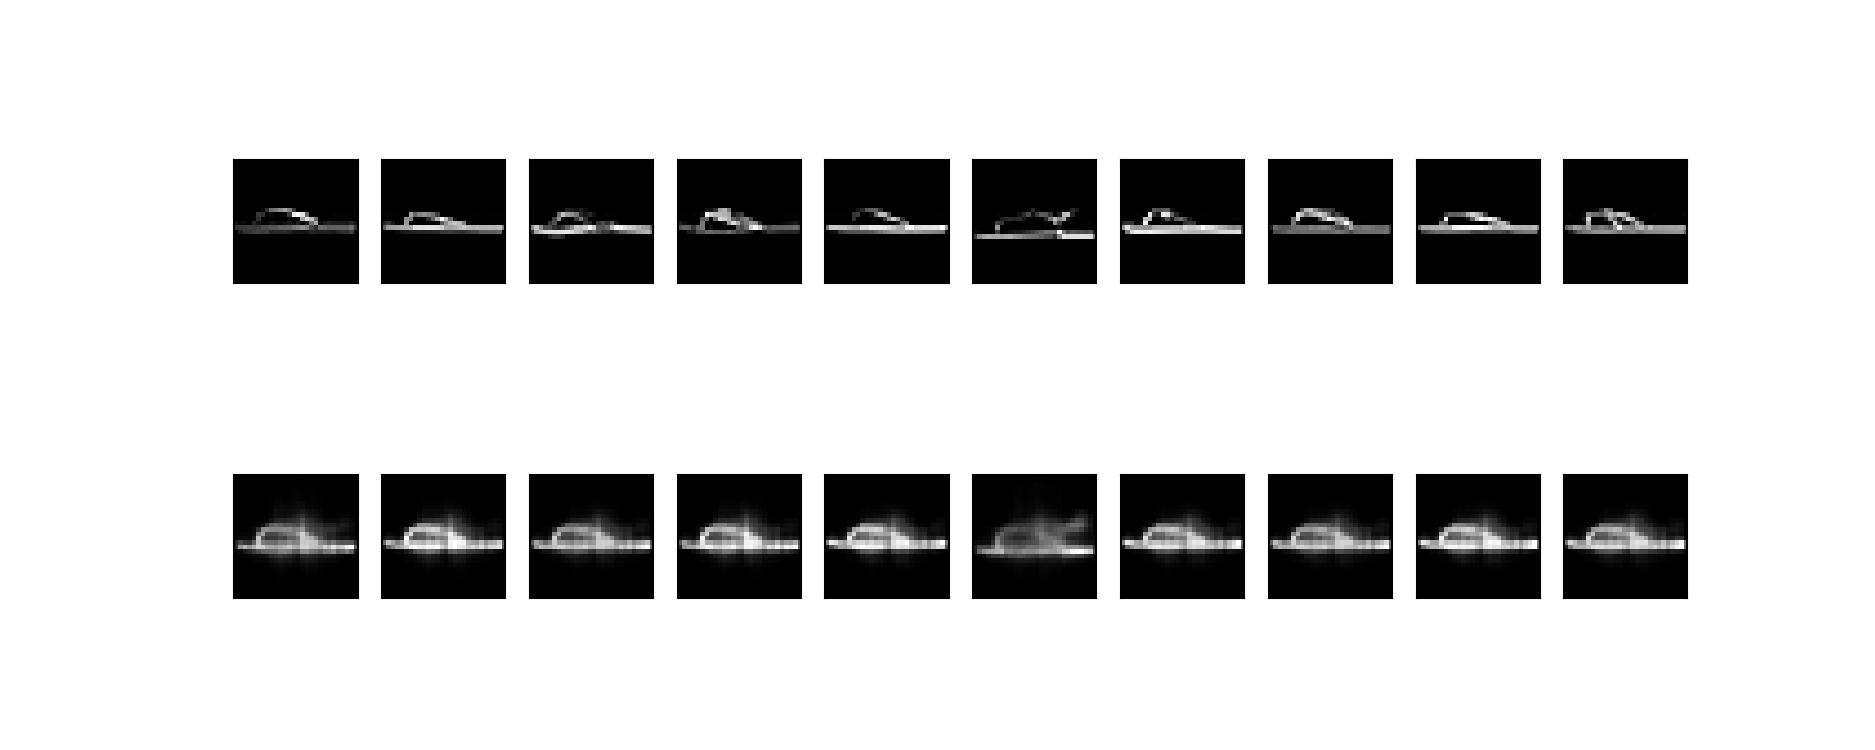

image index: 6428 normal: 1.0 probability: 0.907237
image index: 5582 normal: 1.0 probability: 0.908711
image index: 7993 normal: 1.0 probability: 0.906337
image index: 5413 normal: 1.0 probability: 0.907479
image index: 2453 normal: 1.0 probability: 0.910386
image index: 2206 normal: 1.0 probability: 0.907064
image index: 4075 normal: 1.0 probability: 0.906396
image index: 8872 normal: 1.0 probability: 0.905681
image index: 2667 normal: 1.0 probability: 0.905624
image index: 3902 normal: 1.0 probability: 0.905433


In [34]:
# plot n highest probability reconstructions
n = 10
ten_highest = np.argpartition(-probs, n)
plt.figure(figsize=(10, 4))
for i in range(1,n+1):
    img_idx = ten_highest[i-1]
    print('image index: ' + str(img_idx) +
          ' normal: ' + str(y_test_binary[img_idx]) + 
          ' probability: ' + str(probs[img_idx]))
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_testWithAnomaly[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_recons[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It's also helpful to visualize what are the most anomalous images according to our model.

<IPython.core.display.Javascript object>


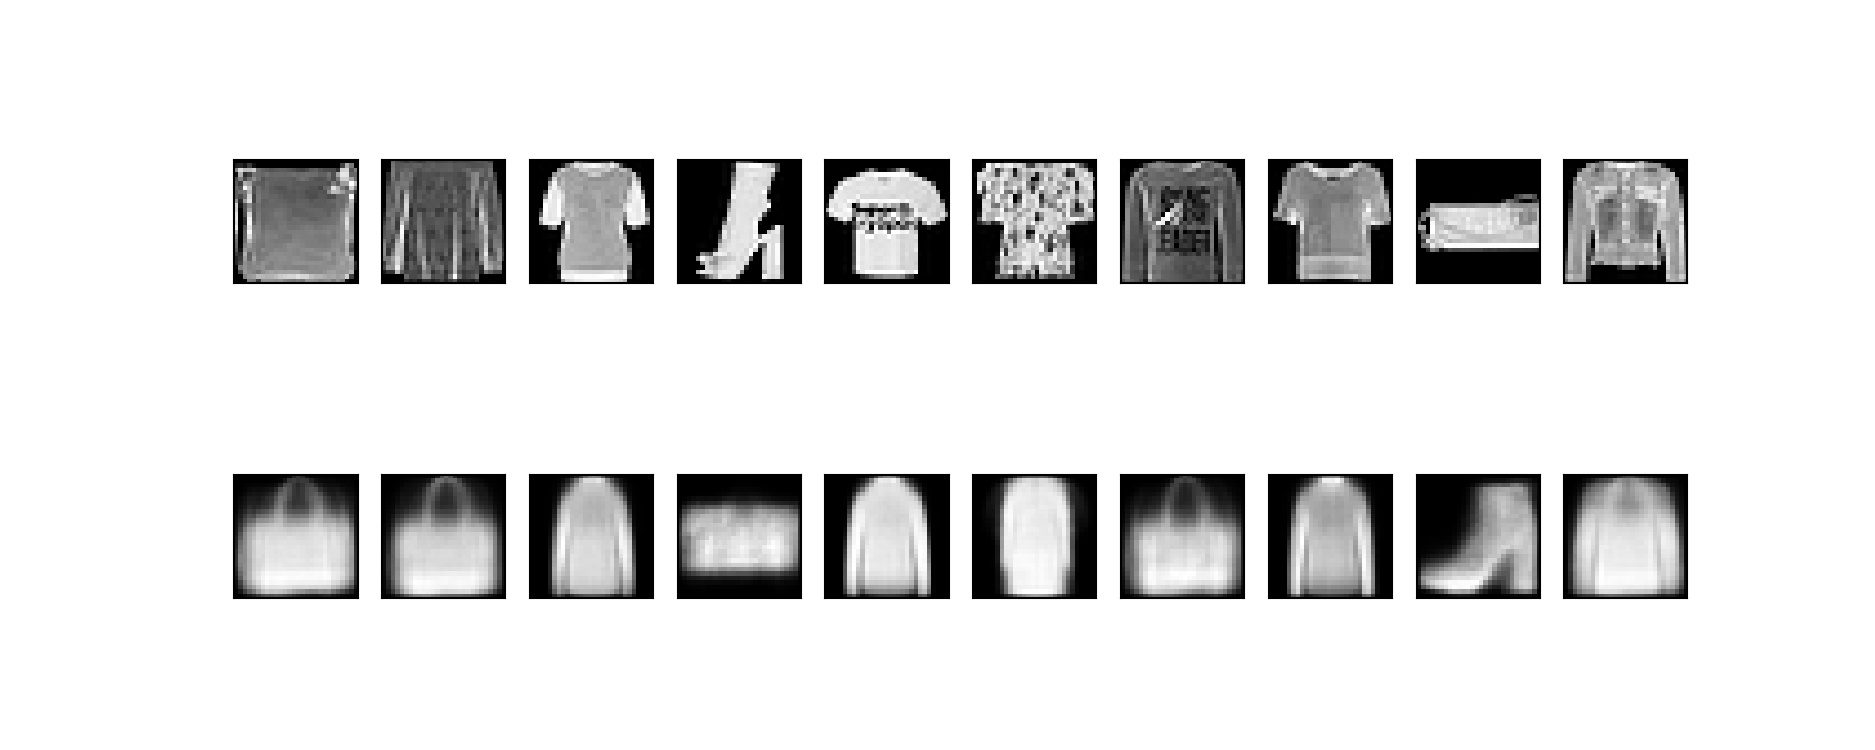

image index: 4115 normal: 1.0 probability: 0.438276
image index: 2367 normal: 1.0 probability: 0.447603
image index: 5272 normal: 1.0 probability: 0.445579
image index: 3999 normal: 1.0 probability: 0.405929
image index: 5943 normal: 1.0 probability: 0.439294
image index: 622 normal: 1.0 probability: 0.413362
image index: 4495 normal: 1.0 probability: 0.451914
image index: 1559 normal: 1.0 probability: 0.43893
image index: 8071 normal: 1.0 probability: 0.442258
image index: 2042 normal: 1.0 probability: 0.455373


In [35]:
# plot n lowest probability reconstructions
n = 10
ten_highest = np.argpartition(probs, n)
plt.figure(figsize=(10, 4))
for i in range(1,n+1):
    img_idx = ten_highest[i-1]
    print('image index: ' + str(img_idx) +
          ' normal: ' + str(y_test_binary[img_idx]) + 
          ' probability: ' + str(probs[img_idx]))
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_testWithAnomaly[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_recons[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

*Question: what can you say about the probabilities of your most anomalous digits?*

*Challenge: change the anomalous digit and retrain the model.  What can we learn about our model?  Is the anomaly detector effective for every anomalous digit?*

*Challenge: retrain the VAE without removing an anomalous digit.  In this case we are training an unsupervised model.  In many anomaly detection tasks there is no labeled training data.  What can we say about the images that are found to be anomalous?*

## Model Evaluation

In order to evaluate the effectiveness of our model we can use different metrics.  In this lab we'll be looking at the ROC curve and computing the AUC.  A diagonal curve means that your model is performing similarly to random chance.  A steep curve indicates a well performing model.  Similarly, an AUC of .5 means random chance and a high AUC means your model is performing well.

In [ ]:
# compute auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

auc = roc_auc_score(y_test_binary, probs)

fpr, tpr, thresholds = roc_curve(y_test_binary, probs)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*Challenge: retrain the VAE using different anomalous digits. How does the anomolous digit affect the AUC?*

Another benefit of VAEs is that since we learned the distribution underlying our data, we can repeatedly sample it.  The more we sample, the lower variance our probability estimate will have.

In [ ]:
# compute reconstruction probabilities with lower variance
num_samples = 100
all_probs = np.zeros((x_test.shape[0], num_samples))
for i in range(num_samples):
    
    x_test_recons = sigmoid_output.predict(x_test)
    
    probs = recon_prob(x_test_recons, x_test)

    all_probs[:, i] = probs

In [ ]:
mean_probs = np.mean(all_probs, axis=1)

In [ ]:
auc_with_sampling = roc_auc_score(y_test_binary, mean_probs)
print('auc with sampling: ' + str(auc_with_sampling))
print('auc: ' + str(auc))

fpr, tpr, thresholds = roc_curve(y_test_binary, mean_probs)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*Challenge: change the number of samples.  How does that affect the AUC?*

In [ ]:
mean_probs*256

In [ ]:
y_test[0]

In [ ]:
anomalyMask = np.where(y_test_binary == 0)
normalMask = np.where(y_test_binary == 1)

In [ ]:
mean_probs[anomalyMask].shape

In [ ]:
np.squeeze(x_test_encoded[anomalyMask, 1]).shape

In [ ]:
if latent_dim == 2:
    # display a 2D plot of the digit classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(20, 10))
    plt.subplot(1,2,1)
    plt.scatter(np.squeeze(x_test_encoded[normalMask, 0]), 
            np.squeeze(x_test_encoded[normalMask, 1]), 
            c=mean_probs[normalMask], cmap='hot', marker='o', s=10 )

    plt.scatter(np.squeeze(x_test_encoded[anomalyMask, 0]), 
                np.squeeze(x_test_encoded[anomalyMask, 1]), 
                c=mean_probs[anomalyMask], cmap='gray', marker='X', s=35 )
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.scatter(np.squeeze(x_test_encoded[:, 0]), 
            np.squeeze(x_test_encoded[:, 1]),
            c=y_test, cmap='tab10',
            marker='o', s=10 )
    plt.colorbar()
    
    plt.show()

## End of Lab

In [ ]:
xNH = Input(shape=(original_dim,))
hNH = Dense(intermediate_dim, activation='relu')(xNH)
z_meanNH = Dense(latent_dim)(hNH)
z_log_varNH = Dense(latent_dim)(hNH)

In [ ]:
vaeNoHoldout = Model(x, y)
vaeNoHoldout.compile(optimizer='rmsprop', loss=None)

In [ ]:
vaeNoHoldout.fit(x_trainNoHoldout,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

## Visualize the Learned Latent Distribution

One of the benefits of variational autoencoders is that we can inspect the latent space to learn more about our model and our data.  In anomaly detection, latent variables can be used to try and determine the cause of anomalies.  This could potentially lead to proactively stopping anomalies from happening.  

In the case that we have 2 latent dimensions we can easily visualize the representation.  With higher dimensionality we can use dimensionality reducing techniques such as PCA or t-SNE to visualize.

Begin by instantiating an encoder model.

In [ ]:
# build a model to project inputs on to the latent space
encoder = Model(x, z_mean)

*Bonus Challenges* 

* Score images from different datasets
* Train on a different dataset